In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class RegressionNet(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output_size=1):
        super(RegressionNet, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_size)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)     # No activation in output for regression
        return out

In [ ]:
# Example dimensions
input_size = 5   # e.g., 5 input features
hidden1 = 64
hidden2 = 32
output_size = 1

# Create model
model = RegressionNet(input_size, hidden1, hidden2, output_size)
# Mean Squared Error Loss for regression
criterion = nn.MSELoss()
# Optimizer — Adam (you can use SGD too)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Random dataset (100 samples, 5 features)
X = torch.randn(100, input_size)
y = torch.randn(100, 1)
#Loss history for loss plot
loss_history = []

In [1]:
## This section is for importing manually available data, if any.
# import pandas as pd
# df = pd.read_csv('data.csv')
# df.head()

# from sklearn.model_selection import train_test_split

# # Features and target
# X = df.drop('target', axis=1)   # replace 'target' with your column name
# y = df['target']

# # Train–test split (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )


# print(X_train.shape, X_test.shape)

In [ ]:
epochs = 500

for epoch in range(epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [20/500], Loss: 0.7645
Epoch [40/500], Loss: 0.6952
Epoch [60/500], Loss: 0.6122
Epoch [80/500], Loss: 0.5243
Epoch [100/500], Loss: 0.4401
Epoch [120/500], Loss: 0.3607
Epoch [140/500], Loss: 0.2849
Epoch [160/500], Loss: 0.2155
Epoch [180/500], Loss: 0.1579
Epoch [200/500], Loss: 0.1121
Epoch [220/500], Loss: 0.0769
Epoch [240/500], Loss: 0.0522
Epoch [260/500], Loss: 0.0349
Epoch [280/500], Loss: 0.0228
Epoch [300/500], Loss: 0.0149
Epoch [320/500], Loss: 0.0098
Epoch [340/500], Loss: 0.0064
Epoch [360/500], Loss: 0.0042
Epoch [380/500], Loss: 0.0027
Epoch [400/500], Loss: 0.0018
Epoch [420/500], Loss: 0.0012
Epoch [440/500], Loss: 0.0008
Epoch [460/500], Loss: 0.0005
Epoch [480/500], Loss: 0.0004
Epoch [500/500], Loss: 0.0002


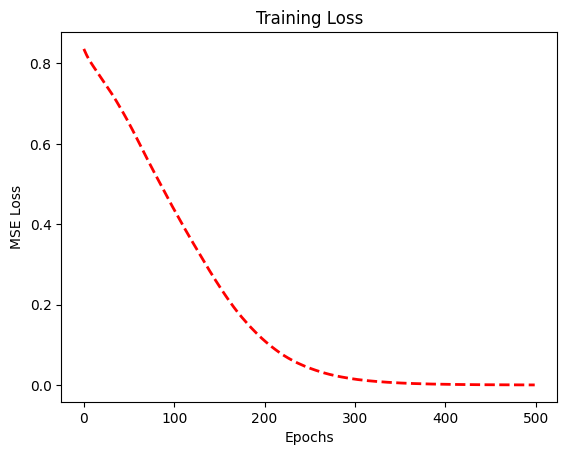

In [ ]:
from matplotlib.lines import lineStyles
import matplotlib.pyplot as plt
plt.plot(loss_history, 'r--', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
#plt.grid(True)
plt.show()


In [ ]:
model.eval()  # set to evaluation mode
with torch.no_grad():
    test_input = torch.randn(3, input_size)
    predicted = model(test_input)
    print("Predicted values:\n", predicted)

Predicted values:
 tensor([[-0.1141],
        [-1.1892],
        [ 0.3475]])


# Solution of **Heat Equation**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x, t):
        # Combine x and t
        X = torch.cat((x, t), dim=1)
        for i in range(len(self.layers)-1):
            X = self.activation(self.layers[i](X))
        X = self.layers[-1](X)
        return X


In [ ]:
def pde_residual(model, x, t, alpha=0.01):
    # Enable gradient computation
    x.requires_grad = True
    t.requires_grad = True
    # Forward pass
    u = model(x, t)
    # Compute partial derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # PDE residual: u_t - alpha * u_xx = 0
    f = u_t - alpha * u_xx
    return f

In [ ]:
# Collocation points (for PDE)
N_f = 10000
x_f = np.random.rand(N_f, 1)
t_f = np.random.rand(N_f, 1)
# Boundary points
N_b = 200
t_b = np.linspace(0, 1, N_b).reshape(-1, 1)
x_b0 = np.zeros_like(t_b)
x_b1 = np.ones_like(t_b)
# Initial condition points
N_i = 200
x_i = np.linspace(0, 1, N_i).reshape(-1, 1)
t_i = np.zeros_like(x_i)
u_i = np.sin(np.pi * x_i)
# Convert all to tensors
to_tensor = lambda x: torch.tensor(x, dtype=torch.float32)
x_f, t_f = to_tensor(x_f), to_tensor(t_f)
x_b0, t_b, x_b1 = to_tensor(x_b0), to_tensor(t_b), to_tensor(x_b1)
x_i, t_i, u_i = to_tensor(x_i), to_tensor(t_i), to_tensor(u_i)


In [ ]:
def loss_function(model):
    # PDE residual loss
    f = pde_residual(model, x_f, t_f)
    loss_f = torch.mean(f**2)

    # Initial condition loss
    u_pred_i = model(x_i, t_i)
    loss_i = torch.mean((u_pred_i - u_i)**2)

    # Boundary condition loss
    u_b0 = model(x_b0, t_b)
    u_b1 = model(x_b1, t_b)
    loss_b = torch.mean(u_b0**2) + torch.mean(u_b1**2)

    return loss_f + loss_i + loss_b

In [ ]:
layers = [2, 50, 50, 50, 1]  # (x,t) → 50 → 50 → 50 → u
model = PINN(layers)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_history = []

In [ ]:
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if (epoch+1) % 1000 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')


Epoch 1000/10000, Loss: 0.000281
Epoch 2000/10000, Loss: 0.000024
Epoch 3000/10000, Loss: 0.000017
Epoch 4000/10000, Loss: 0.000015
Epoch 5000/10000, Loss: 0.000019
Epoch 6000/10000, Loss: 0.000010
Epoch 7000/10000, Loss: 0.000431
Epoch 8000/10000, Loss: 0.000008
Epoch 9000/10000, Loss: 0.000008
Epoch 10000/10000, Loss: 0.000006


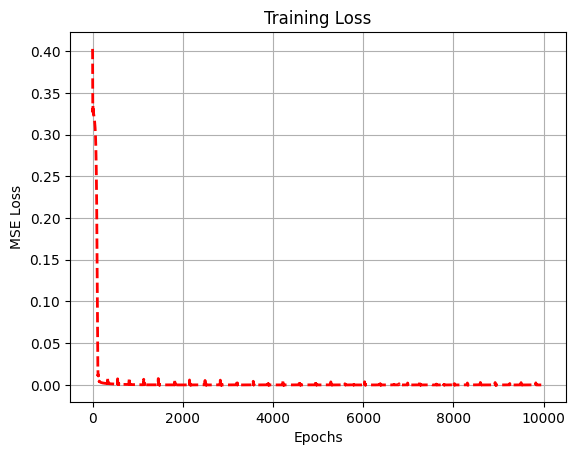

In [ ]:
from matplotlib.lines import lineStyles
import matplotlib.pyplot as plt
plt.plot(loss_history, 'r--', linewidth=2)
#plt.ylim([0.00001, 0.05])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

In [ ]:
#loss_history

In [ ]:
test_loss_history = []

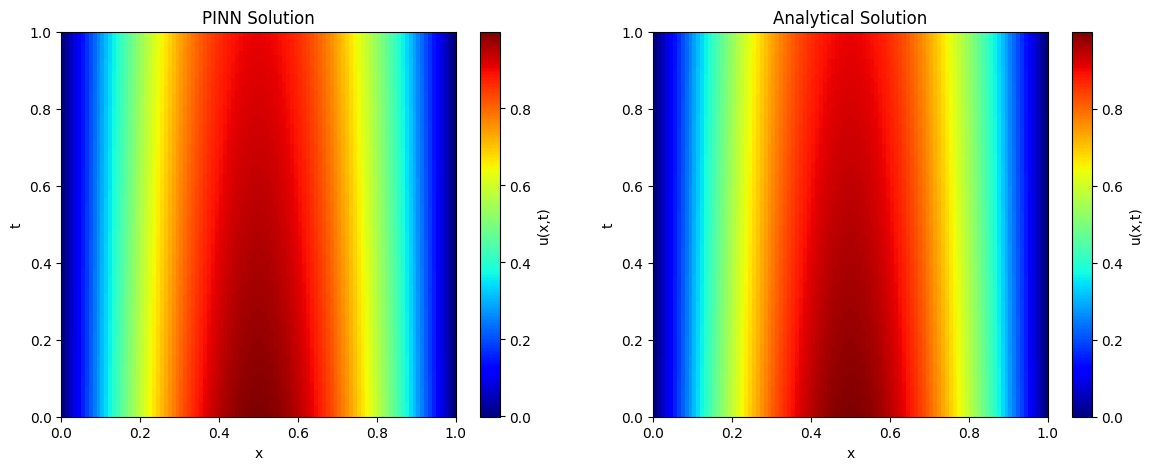

In [ ]:
# Create test grid
x_test = np.linspace(0, 1, 100)
t_test = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_test, t_test)
x_test_t = torch.tensor(X.flatten()[:, None], dtype=torch.float32)
t_test_t = torch.tensor(T.flatten()[:, None], dtype=torch.float32)


# Predict using trained model
u_pred = model(x_test_t, t_test_t).detach().numpy()
test_loss_history.append(loss.item())
U_pred = u_pred.reshape(100, 100)
# Exact analytical solution
alpha=0.01
U_exact = np.exp(-alpha * np.pi**2 * T) * np.sin(np.pi * X)



# Plot results
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(U_pred, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='jet')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(label='u(x,t)')
plt.title('PINN Solution')

plt.subplot(1,2,2)
plt.imshow(U_exact, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='jet')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar(label='u(x,t)')
plt.title('Analytical Solution')
plt.show()


In [ ]:
test_loss_history

[5.903329565626336e-06]

In [ ]:
x_test = np.linspace(0, 1, 100)
t_test = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_test, t_test)

x_test_t = torch.tensor(X.flatten()[:, None], dtype=torch.float32)
t_test_t = torch.tensor(T.flatten()[:, None], dtype=torch.float32)

x_test_t.requires_grad = True
t_test_t.requires_grad = True


def test_residual_loss(model, x, t):
    # compute PDE residual
    f = pde_residual(model, x, t)
    return torch.mean(f**2)

In [ ]:
test_residual = test_residual_loss(model, x_test_t, t_test_t).item()
print("Test residual:", test_residual)

Test residual: 5.071244231658056e-06
